In [1]:
import numpy as np
from scipy.io import wavfile
from scipy import signal

import matplotlib.pyplot as plt

In [2]:
def find_carrier(wav_data, sample_rate):
    f, Pxx_den = signal.welch(wav_data, sample_rate, nperseg=2048)
    
    max_value = np.argmax(Pxx_den)
    carrier_freq = f[max_value]
    
    return carrier_freq


def process_audio_with_stft(wav_data, sample_rate, window_size_ms=10):
    # Размер окна в сэмплах (например, для 10 миллисекунд)
    window_size_samples = int(sample_rate * window_size_ms / 1000)

    # Вычисление STFT
    f, t, Zxx = signal.stft(wav_data, fs=sample_rate, nperseg=window_size_samples)

    # Амплитуды спектра
    amplitude = np.abs(Zxx)
    # Возвращаем частоты, времена и амплитуды
    return f, t, amplitude


def calc_grad_std(data):
    grad = np.diff(data)  # Градиент как разности между соседними значениями
    dev = np.std(grad)
    return dev


def butter_bpf(data, sample_rate, frequency, bandwidth=50, filter_order=4):
    nyquist_rate = sample_rate / 2.0
    low_cutoff = (frequency - bandwidth / 2) / nyquist_rate  # Нижняя частота полосы пропускания
    high_cutoff = (frequency + bandwidth / 2) / nyquist_rate  # Верхняя частота полосы пропускания
   
    b, a = signal.butter(filter_order, [low_cutoff, high_cutoff], btype='bandpass')

    filtered = signal.filtfilt(b, a, data)
    return filtered


def smooth_signal(data, sample_rate, window_length=0.0025):
    window = signal.windows.hann(int(sample_rate * window_length))
    smooth = signal.convolve(data, window, mode="same") / sum(window)
    return smooth

In [3]:
# file_path = "cw/morse650hz.wav"
file_path = "cw/cw-sample1.wav"

sample_rate, wav_data = wavfile.read(file_path)

max_val = np.max(np.abs(wav_data), axis=0) 
wav_data = wav_data / max_val

/tmp/ipykernel_50/4210008225.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, wav_data = wavfile.read(file_path)


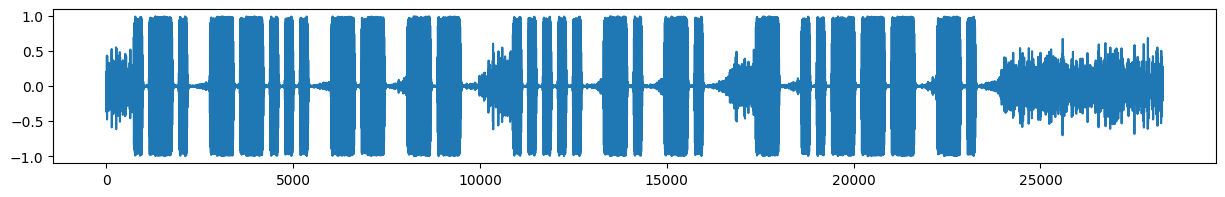

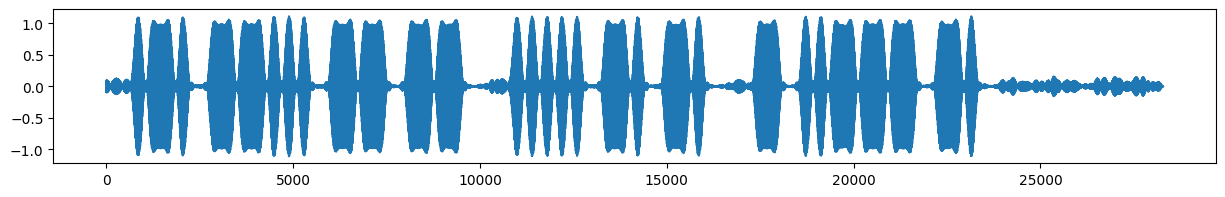

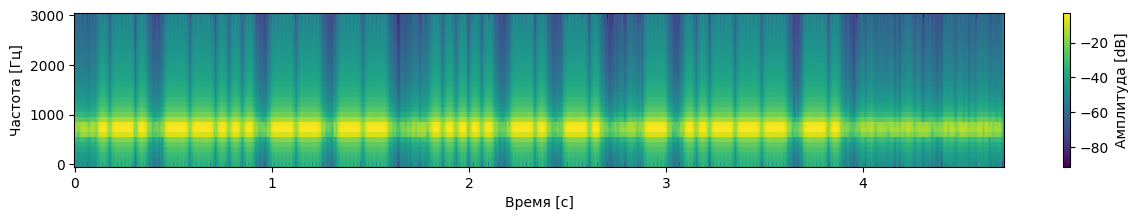

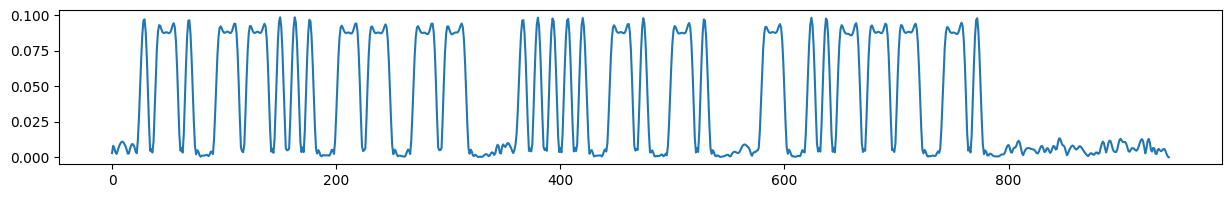

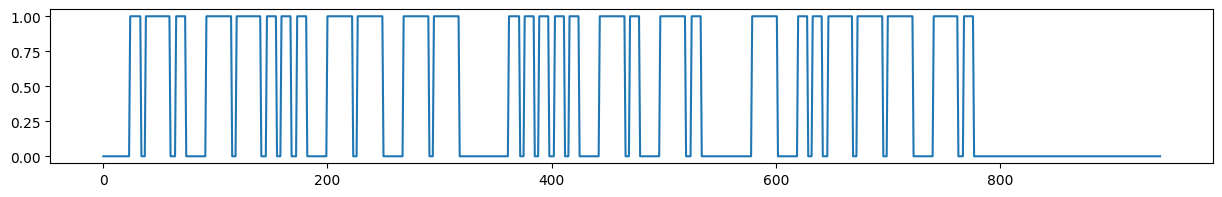

In [4]:
carrier = find_carrier(wav_data, sample_rate)
filtered_wav_data = butter_bpf(wav_data, sample_rate, carrier)
frequencies, times, amplitudes = process_audio_with_stft(filtered_wav_data, sample_rate)

plt.figure(figsize=(15, 2))
plt.plot(wav_data)
plt.show()

plt.figure(figsize=(15, 2))
plt.plot(filtered_wav_data)
plt.show()

plt.figure(figsize=(15, 2))
plt.pcolormesh(times, frequencies, 10 * np.log10(amplitudes), shading='auto') # 10 * np.log10(amplitudes)
plt.ylabel('Частота [Гц]')
plt.xlabel('Время [с]')
#plt.title('Спектрограмма аудиофайла')
plt.colorbar(label='Амплитуда [dB]')
plt.show()

gen = (
    calc_grad_std(amplitudes[:, i]) 
    for i, time_point in enumerate(times)
)
grads = np.fromiter(gen, dtype=float)
# grads = smooth_signal(grads, sample_rate, window_length=0.0025)

square_wave = np.where(grads > 0.02, 1, 0)

plt.figure(figsize=(15, 2))
plt.plot(grads)
plt.show()

plt.figure(figsize=(15, 2))
plt.plot(square_wave)
plt.show()

In [5]:
MORSE_LETTERS = {
    "A": ".-", "B": "-...", "C": "-.-.", "D": "-..", "E": ".", "F": "..-.", "G": "--.", "H": "....", "I": "..",
    "J": ".---", "K": "-.-", "L": ".-..", "M": "--", "N": "-.", "O": "---", "P": ".--.", "Q": "--.-", "R": ".-.",
    "S": "...", "T": "-", "U": "..-", "V": "...-", "W": ".--", "X": "-..-", "Y": "-.--", "Z": "--..",
}

MORSE_DIGITS = {
    "0": "-----", "1": ".----", "2": "..---", "3": "...--", "4": "....-",
    "5": ".....", "6": "-....", "7": "--...", "8": "---..", "9": "----.",
}

MORSE_PUNCTS = {
    ".": ".-.-.-", ",": "--..--", "?": "..--..",
}

MORSE_TABLE = {
    **MORSE_LETTERS,
    **MORSE_DIGITS,
    **MORSE_PUNCTS,
    " ": " ",
}

MORSE_DECODE = {
    v: k for k, v in MORSE_TABLE.items()
}

In [6]:
from sklearn.cluster import KMeans
from itertools import groupby

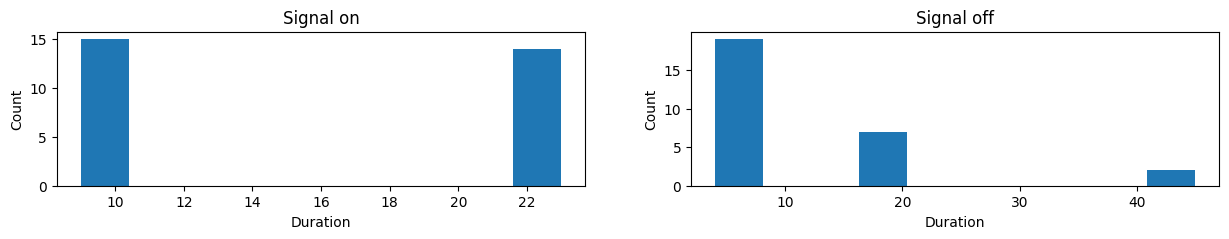

In [7]:
square_diff = np.diff(square_wave)

rising_idx = np.nonzero(square_diff == 1)[0]
falling_idx = np.nonzero(square_diff == -1)[0]

# Case: data starts with ON - it started one sample before index 0
if falling_idx[0] < rising_idx[0]:
    rising_idx = np.insert(rising_idx, 0, -1)

# Case: data ends with ON
if rising_idx[-1] > falling_idx[-1]:
    falling_idx = np.insert(falling_idx, len(falling_idx), len(falling_idx) - 1)

on_samples = falling_idx - rising_idx
off_samples = rising_idx[1:] - falling_idx[: len(falling_idx) - 1]

fig, axes = plt.subplots(1, 2, figsize=(15, 2))
axes[0].hist(on_samples)
axes[0].set_title("Signal on")

axes[1].hist(off_samples)
axes[1].set_title("Signal off")

for ax in axes:
    ax.set_ylabel("Count")
    ax.set_xlabel("Duration")

In [8]:
one_lengths = on_samples.reshape(-1, 1)
zero_lengths = off_samples.reshape(-1, 1)

def morse_clustering_decode(ones, zeros):
    # Ones
    kmeans_ones = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(one_lengths)
    one_cluster_sort_idx = np.argsort(kmeans_ones.cluster_centers_.flatten()).tolist()
    dot_label = one_cluster_sort_idx.index(0)
    dash_label = one_cluster_sort_idx.index(1)
    one_map = {dot_label: '.', dash_label: '-'}
    # Zeros
    kmeans_zeros = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(zero_lengths)
    zero_cluster_sort_idx = np.argsort(kmeans_zeros.cluster_centers_.flatten()).tolist()
    nonbreak_label = zero_cluster_sort_idx.index(0)
    space_label = zero_cluster_sort_idx.index(1)
    break_label = zero_cluster_sort_idx.index(2)
    # Chunking
    chunks = [(gr, sum(1 for it in items)) for gr, items in groupby(square_wave)]
    morse_words = []
    morse_str = ''
    for bit, count in chunks:
        if bit == 1:  # Определяем точка или тире
            one_label = kmeans_ones.predict([[count]])[0]
            symbol = one_map[one_label]
            # print(count, one_label, symbol)
            morse_str += symbol
        else:
            zero_label = kmeans_zeros.predict([[count]])[0]
            if zero_label == space_label:
                morse_str += ' '
            elif zero_label == break_label:
                morse_words.append(morse_str)
                morse_str = ''
    
    if morse_str:
        morse_words.append(morse_str)

    return morse_words

morse_words = morse_clustering_decode(one_lengths, zero_lengths)
for morse_word in morse_words:
    word_list = list(map(lambda m: MORSE_DECODE.get(m, f"<{m}>"), morse_word.split()))
    print("Text:", "".join(word_list), "\t\tMorse:", morse_word)

Text: R7MM 		Morse:  .-. --... -- --
Text: 5NN 		Morse: ..... -. -.
Text: T2N 		Morse: - ..--- -.
